<a href="https://colab.research.google.com/github/Alemzhan-A/Linear-Regression_Yandex/blob/main/Regression_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Готовим данные

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy import stats

df = pd.read_csv(" https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv", na_values=["?"])

In [ ]:
y = pd.DataFrame(df["Claim"])
df_ = df.drop(['Claim'], axis=1)
cat_features_mask = (df_.dtypes == "object").values
df_num = df_[df_.columns[~cat_features_mask]]
df_cat_no = df_[df_.columns[cat_features_mask]].fillna("")
df_no = pd.concat([df_num, df_cat_no], axis=1)
df_num.describe()

,Duration,Net Sales,Commision (in value),Age
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


Тут видно, что в каждой фиче у нас есть выброс, который отрицательно влияет на модель. Попробуем визуализировать и посмотреть насколько эти выбросы велики. Я решил посмотреть 'Duration" и "Age"

In [ ]:
import plotly.express as px
fig = px.histogram(df_num, x='Duration')
fig.show()

In [ ]:
fig = px.histogram(df_num, x='Age')
fig.show()

## Различные способы преобразований

1 - Способ(удаление выбросов). Я использовал либу scipy и взял оттуда индекс стандартного отклонения(zscore), чтобы отсеить выбросы. Также я посмотрел, что можно было использовать квартили, но остановился на zscore,потому что его результаты меня удовлетворили

In [ ]:
df_num1 = df_num[(np.abs(stats.zscore(df_num)) < 2.5).all(axis=1)]
df_num1.describe()
df_all = pd.concat([df_num1, df_cat_no], axis=1)
df_all = df_all.dropna()
df_all.describe()

,Duration,Net Sales,Commision (in value),Age
count,58737.000000,58737.000000,58737.000000,58737.000000
mean,36.730664,32.788649,6.251516,38.438242
std,43.551579,25.971035,10.808046,9.579587
min,0.000000,-80.000000,0.000000,5.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,21.000000,25.000000,0.000000,36.000000
75%,47.000000,41.000000,9.100000,42.000000
max,303.000000,162.000000,59.150000,75.000000


2 - Способ(Удалить все категориальные фичи и оставить только числовые фичи)

In [ ]:
df_all_without_features = df_num
df_all_without_features

,Duration,Net Sales,Commision (in value),Age
0,186,-29.0,9.57,81
1,186,-29.0,9.57,71
2,65,-49.5,29.70,32
3,60,-39.6,23.76,32
4,79,-19.8,11.88,41
...,...,...,...,...
63321,111,35.0,12.25,31
63322,58,40.0,14.00,40
63323,2,18.0,6.30,57
63324,3,18.0,6.30,63


3 - Способ(Удалить категориальные фичи, которые имеют много столбцов после onehotencoding). Конкретно в данном случае я удалил столбец destination(мейби ошибка), потому что оно имеет 149 столбцов после енкодинга, когда другие фичи создают относительно мало столбцов

In [ ]:
df_cat_no = df_cat_no.drop(["Destination"],axis=1)
df_all_without_destination = pd.concat([df_num1, df_cat_no], axis=1)
df_all_without_destination

,Duration,Net Sales,Commision (in value),Age,Agency,Agency Type,Distribution Channel,Product Name,Gender
1,186.0,-29.0,9.57,71.0,CBH,Travel Agency,Offline,Comprehensive Plan,F
2,65.0,-49.5,29.70,32.0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,
3,60.0,-39.6,23.76,32.0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,
4,79.0,-19.8,11.88,41.0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,
6,47.0,-39.6,23.76,32.0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,
...,...,...,...,...,...,...,...,...,...
63233,NaN,NaN,NaN,NaN,C2B,Airlines,Online,Annual Gold Plan,F
63234,NaN,NaN,NaN,NaN,C2B,Airlines,Online,Annual Gold Plan,M
63239,NaN,NaN,NaN,NaN,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,
63240,NaN,NaN,NaN,NaN,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,


4 - Способ(Downsampling)

In [ ]:
print(y.value_counts())
y.size


Claim
No       62399
Yes        927
dtype: int64


63326

Как мы видим, "No" слишком много относительно "Yes". Поэтому нужно уменьшить количество "No" до того же уровня, что и "Yes",так как иначе модель которая просто выдает нули будет очень эффективной(Будет маленький MSE), хотя на самом деле она так работать не должна

In [ ]:
from sklearn.utils import resample
yes = y[y["Claim"] == "Yes"]
no = y[y["Claim"] == "No"]
no_downsample = resample(no,
             replace=True,
             n_samples=len(yes),
             random_state=42)

print(no_downsample.shape)
y_downsampled = pd.concat([no_downsample, yes])
y_downsampled

(927, 1)


,Claim
57256,No
15908,No
870,No
38604,No
55111,No
...,...
63173,Yes
63199,Yes
63206,Yes
63208,Yes


Теперь мы получили равное количество "Yes" и "No", что по идее выдаст более реальные результаты

## Линейная регрессия

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, recall_score, precision_score
from sklearn.linear_model import LinearRegression

#Onehotencoding и MinmaxScaler
df_dum = pd.get_dummies(df_all, drop_first=True)
normalizer = preprocessing.MinMaxScaler()
df_all2 = normalizer.fit_transform(df_dum)
df_all3 = pd.DataFrame(df_all2)
df_all3.columns = df_dum.columns
df_all = df_all3


#Аналитическое решение
X = df_all
y = pd.DataFrame((np.where(df['Claim'] == 'Yes', 1,0)), columns=["Claim"])
df_res = pd.concat([X, y], axis=1)
df_res = df_res.dropna()
y_res = df_res['Claim']
X_res = df_res.drop(['Claim'], axis=1)




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.8,random_state=77)
n, k = X_train.shape
X_train = np.hstack((np.ones((n, 1)), X_train))
XT = X_train.T
w = np.linalg.inv(XT @ X_train) @ XT @ y_train
w

LinAlgError: Singular matrix

Получили ошибку о том, что матрица вырождена. Это может быть из-за того, что некоторые фичи зависимы от друг-друга. Поэтому сделаем l2-регуляризацию

In [ ]:
E = np.eye(k + 1)
lambda_ = 1
w = np.linalg.inv(X_train.T @ X_train + lambda_ ** 2 * E) @ X_train.T @ y_train
w


array([ 0.03748772, -0.00556791, -0.00524101,  0.00590213, -0.00186087,
       -0.01131143,  0.0177618 , -0.04096216, -0.04212357, -0.02357384,
       -0.001748  , -0.00143444,  0.01487658,  0.00509675,  0.00544303,
       -0.00320612,  0.00580036, -0.02741788,  0.01356653, -0.03869466,
       -0.00159962,  0.03022455,  0.00455065,  0.00331825, -0.00075442,
       -0.00552889,  0.00736839,  0.00057607, -0.001748  ,  0.00707516,
        0.00169889,  0.00576503, -0.0020209 ,  0.00580036, -0.01531847,
       -0.01209941,  0.00926049, -0.00803673, -0.00571781, -0.00140471,
        0.00401591, -0.00646826, -0.00467098, -0.00653434, -0.00695255,
       -0.0032971 , -0.00971463,  0.02304227, -0.00357011, -0.00352144,
       -0.00520033, -0.00441796,  0.        , -0.00276618, -0.00595907,
        0.01177986, -0.00594575,  0.0038061 , -0.00171224,  0.01494159,
       -0.00202494, -0.00492235,  0.01206451, -0.00466491, -0.00438533,
        0.03781091, -0.00555732, -0.00618332,  0.02268206, -0.00

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.8,random_state=77)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_pred = [1 if i>0.5 else 0 for i in y_pred]
mse = mean_squared_error(y_test, y_pred)

print(mse)

0.014470548178413346


Как мы видим , среднее MSE для модели, в которой просто были удалены выбросы, равно 0.014470548178413346. Теперь попробуем способ, когда удалены все категориальные фичи

0.014624190746881411
0.0
0.0


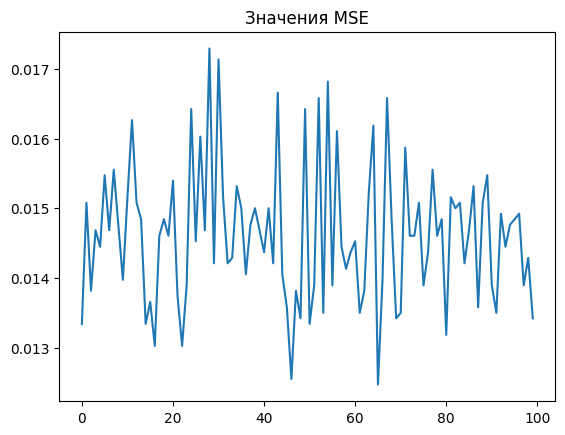

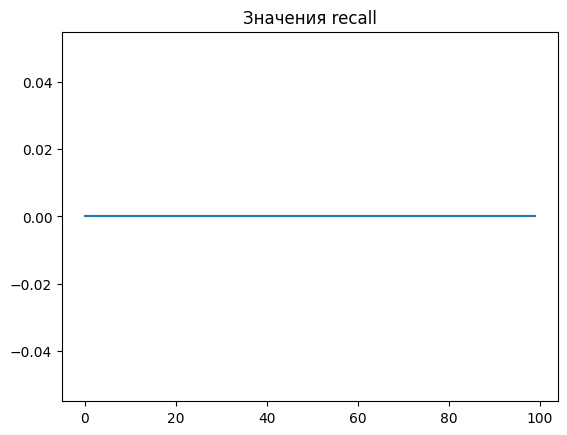

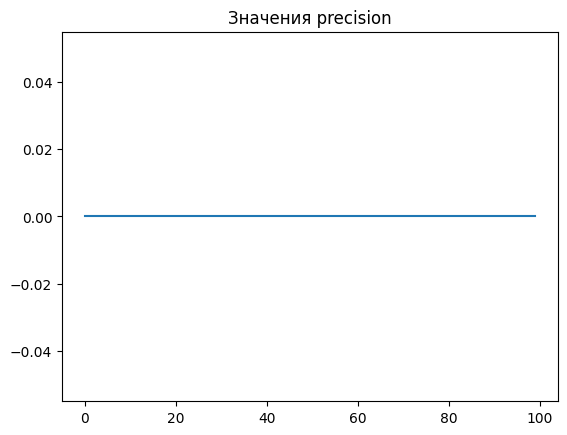

In [ ]:
df_dum = pd.get_dummies(df_all_without_features, drop_first=True)
normalizer = preprocessing.MinMaxScaler()
df_all2 = normalizer.fit_transform(df_dum)
df_all3 = pd.DataFrame(df_all2)
df_all3.columns = df_dum.columns


X = df_all3
y = pd.DataFrame((np.where(df['Claim'] == 'Yes', 1,0)), columns=["Claim"])
df_res = pd.concat([X, y], axis=1)
df_res = df_res.dropna()
y_res = df_res['Claim']
X_res = df_res.drop(['Claim'], axis=1)

mses = []
recalls = []
precisions = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.8,random_state=i)
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    y_pred = [1 if i>0.5 else 0 for i in y_pred]
    mse = mean_squared_error(y_test, y_pred)
    recall = recall_score(y_test,y_pred,zero_division=0)
    precision = precision_score(y_test,y_pred,zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    mses.append(mse)
print(sum(mses)/100)
print(sum(recalls)/100)
print(sum(precisions)/100)
plt.plot(np.arange(100), mses)
plt.title('Значения MSE')
plt.show()
plt.plot(np.arange(100), recalls)
plt.title('Значения recall')
plt.show()
plt.plot(np.arange(100), precisions)
plt.title('Значения precision')
plt.show()

Здесь MSE равен 0.014624190746881411. Попробуем теперь удалить только колонну destination

0.014386278515491995
0.0
0.0


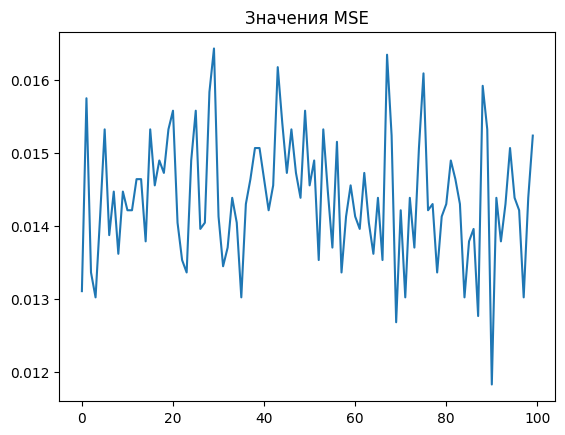

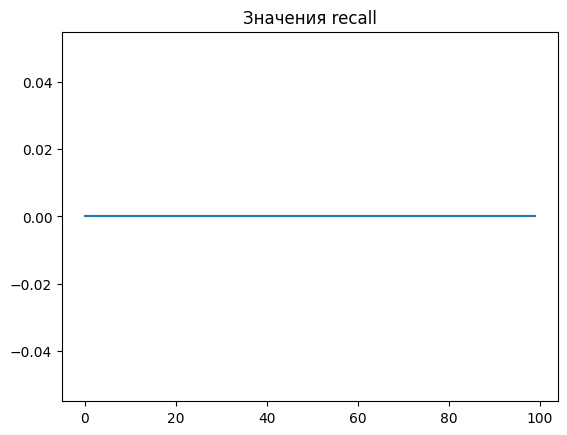

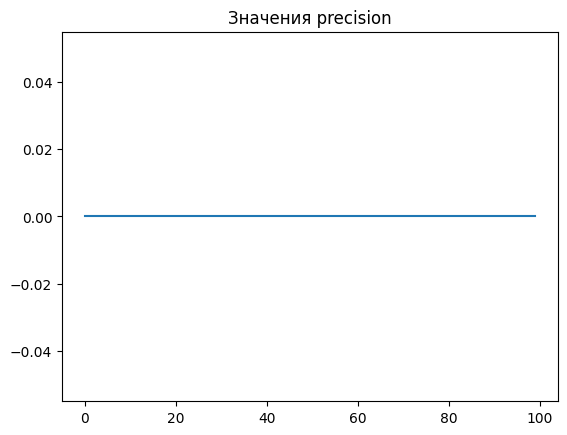

In [ ]:
df_dum = pd.get_dummies(df_all_without_destination, drop_first=True)
normalizer = preprocessing.MinMaxScaler()
df_all2 = normalizer.fit_transform(df_dum)
df_all3 = pd.DataFrame(df_all2)
df_all3.columns = df_dum.columns


X = df_all3
y = pd.DataFrame((np.where(df['Claim'] == 'Yes', 1,0)), columns=["Claim"])
df_res = pd.concat([X, y], axis=1)
df_res = df_res.dropna()
y_res = df_res['Claim']
X_res = df_res.drop(['Claim'], axis=1)

mses = []
recalls = []
precisions = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.8,random_state=i)
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    y_pred = [1 if i>0.5 else 0 for i in y_pred]
    mse = mean_squared_error(y_test, y_pred)
    recall = recall_score(y_test,y_pred,zero_division=0)
    precision = precision_score(y_test,y_pred,zero_division = 0)
    precisions.append(precision)
    recalls.append(recall)
    mses.append(mse)
print(sum(mses)/100)
print(sum(recalls)/100)
print(sum(precisions)/100)
plt.plot(np.arange(100), mses)
plt.title('Значения MSE')
plt.show()
plt.plot(np.arange(100), recalls)
plt.title('Значения recall')
plt.show()
plt.plot(np.arange(100), precisions)
plt.title('Значения precision')
plt.show()

Без колонны destination MSE равен 0.014386278515491995. Теперь попробуем сделать с downsampling



0.48037735849056623
0.5293176807853786
0.5272868918493093


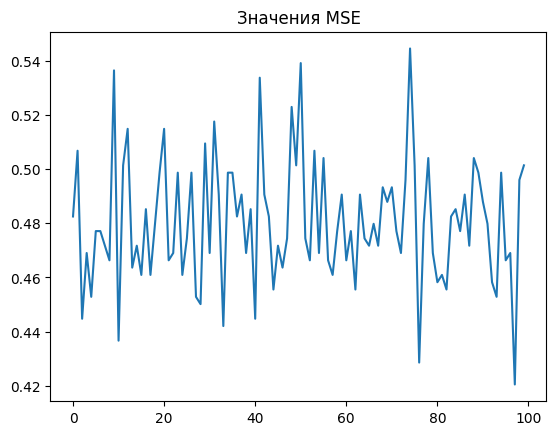

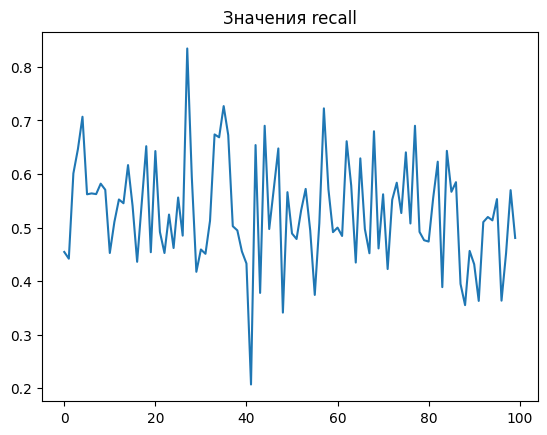

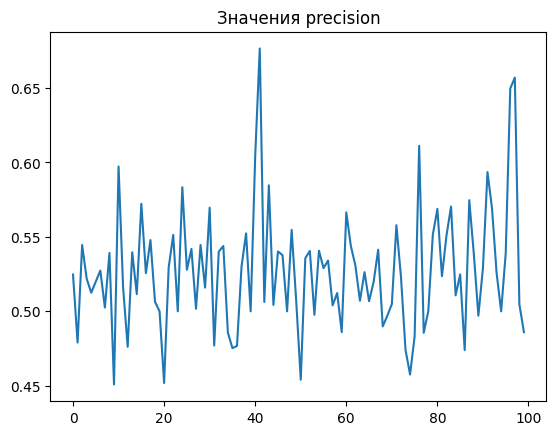

In [ ]:
df_dum = pd.get_dummies(df_all_without_destination, drop_first=True)
normalizer = preprocessing.MinMaxScaler()
df_all2 = normalizer.fit_transform(df_dum)
df_all3 = pd.DataFrame(df_all2)
df_all3.columns = df_dum.columns


X = df_all3
y = pd.DataFrame((np.where(y_downsampled['Claim'] == 'Yes', 1,0)), columns=["Claim"])
df_res = pd.concat([X, y], axis=1)
df_res = df_res.dropna()
y_res = df_res['Claim']
X_res = df_res.drop(['Claim'], axis=1)

mses = []
recalls = []
precisions = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.8,random_state=i)
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    y_pred = [1 if i>0.5 else 0 for i in y_pred]
    mse = mean_squared_error(y_test, y_pred)
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    precisions.append(precision)
    recalls.append(recall)
    mses.append(mse)
print(sum(mses)/100)
print(sum(recalls)/100)
print(sum(precisions)/100)
plt.plot(np.arange(100), mses)
plt.title('Значения MSE')
plt.show()
plt.plot(np.arange(100), recalls)
plt.title('Значения recall')
plt.show()
plt.plot(np.arange(100), precisions)
plt.title('Значения precision')
plt.show()

Как мы видим, MSE стал равен 0.48037735849056623, что, я считаю, близко к реальности.

# **Вывод**: Я выбрал для конечного результата модели методы удаления выбросов, downsampling и удаление колонны destination. Downsampling помог приблизить результат модели к реальному результату, потому что до сэпмлинга кол-во "No" было намного больше "Yes" и любая модель, которая бы выдавала на все "0" имело бы маленький MSE. Удалил колонну destination, потому что после энкодинга люди из некоторых стран вообще не будут иметь "1" в столбце "Claim". Из этого было целесообразно удалить и/или группировать значения в Destination. Моя модель имеет MSE 0.48, что относительно плохо, потому что оно далеко от нуля
# **Вывод #2**: теперь, после обратной связи, я понял, что последняя полученная модель является наилучшей, так как она имеет среднее значение recall: 0.5293176807853786 , precision: 0.5272868918493093 , когда остальные модели без downsampling-а имеют значения recall и precision равные нулю. С помощью этих способов оценки модели я осознал, что первые две полученные модели вообще не правильно предсказывает единички, хоть и имеют довольно маленький MSE. Это связано с тем, что модель просто выдает нули